In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib

import datetime
from helpers import *
from implementations import *


In [2]:
datapath = r"C:\Users\herma\OneDrive\Bureau\Etudes EPFL\ma3\ML\ML_course\projects\project1\data"

x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path=datapath,sub_sample=False)


## Normalization and data processing:

In [3]:
with open(datapath+'/x_train.csv', newline='') as csvfile: 
    csv_reader = csv.reader(csvfile)
    feature_names = next(csv_reader)
feature_names=feature_names[1:]


x_test0=normalize_and_fill(x_test, feature_names)
x_train0=normalize_and_fill(x_train, feature_names)
print(np.isnan(x_train0).sum())


c:\Users\herma\OneDrive\Bureau\Etudes EPFL\ma3\ML\ML_course\projects\project1\RENDU\implementation.py:719: RuntimeWarning: invalid value encountered in divide
  X_normalized[:, i] = np.where(~np.isnan(column), (column - mean) / std, column)


0


In [122]:
#SPLIT DATA IN TRAIN AND TEST (85-15)   -->  so that, we can try to estimate our f1 accuracy later
#never train on this test set, the cross validation is done on the train only 

X_tr_, X_te_, Y_tr_, Y_te_=split_data(x=x_train0, y=y_train, ratio=0.85, seed=48) #1481 #28 #71


## First approach: Data augmentation:  

In [111]:
#DATA UNBALANCED
#FIRST APPROACH: duplicate +1 samples
#here as the label +1 are much less represented than label -1, we try to duplicate the sample with label +1, we duplicate N times

#another approach is done after, with data reduction, lets see which one perform better !
#note: instead of using data augmentation, we could have used weighted logistic loss and gradient, but the results are the same

N_values = [1,2,3,4,5,6]  
y_train_over_N = {}
X_train_over_N = {}
indices = np.where(Y_tr_ == 1)[0]

# run over the different N values
for N in N_values:
    y_augment = []
    for value in Y_tr_:
        if value == 1:
            y_augment.extend([1] * N)  
        else:
            y_augment.append(value)  
    y_train_over_N[N] = np.array(y_augment)
        
    duplicated_rows = []
    for i in range(len(X_tr_)):
        if i in indices:
            duplicated_rows.extend([X_tr_[i]] * N) 
        else:
            duplicated_rows.append(X_tr_[i])  
    X_train_over_N[N] = np.array(duplicated_rows)


In [112]:
# We add a first row full of one to have the constant term  -->  y = w0 +w1*X1 + ...
x_train_with1 = {}

print("test")
for n in N_values:
    #x_train_with1[n] = np.concatenate((np.ones((x_out_augmentation.shape[0], 1)), x_out_augmentation), axis=1)
        x_train_with1[n] = np.concatenate((np.ones((X_train_over_N[n].shape[0], 1)), X_train_over_N[n]), axis=1)

x_testSplit_with1 = np.concatenate((np.ones((X_te_.shape[0], 1)), X_te_), axis=1)
x_test_with1= np.concatenate((np.ones((x_test0.shape[0], 1)), x_test0), axis=1)

test


# RIDGE REGRESSION 1
(with augmented dataset)

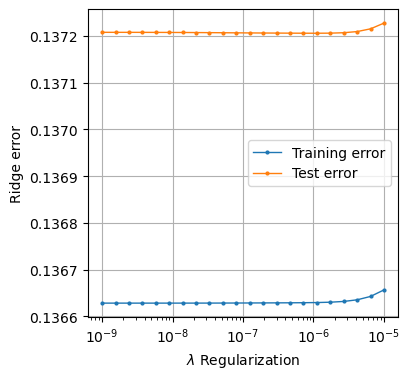

index of min :  16
lamdna at the min :  1.1158839925077481e-06


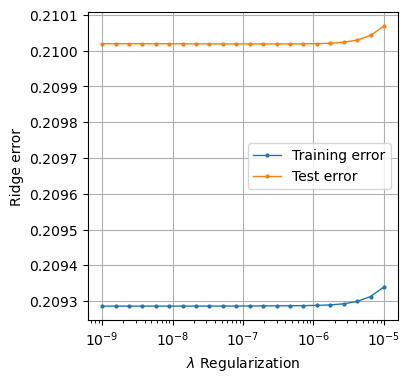

index of min :  12
lamdna at the min :  1.9306977288832497e-07


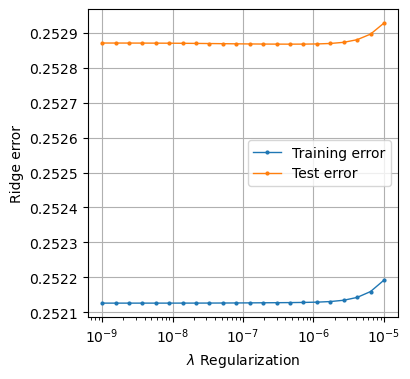

index of min :  14
lamdna at the min :  4.6415888336127725e-07


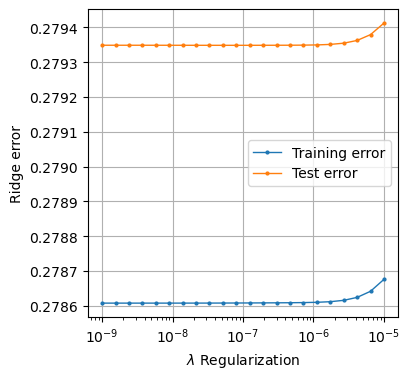

index of min :  9
lamdna at the min :  5.1794746792312124e-08


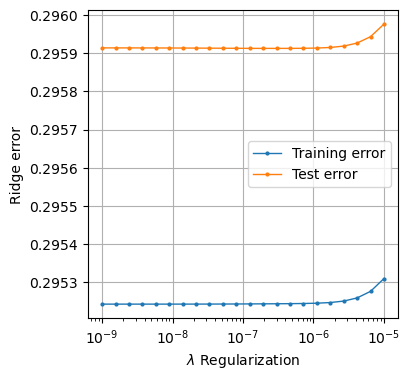

index of min :  13
lamdna at the min :  2.9935772947204905e-07


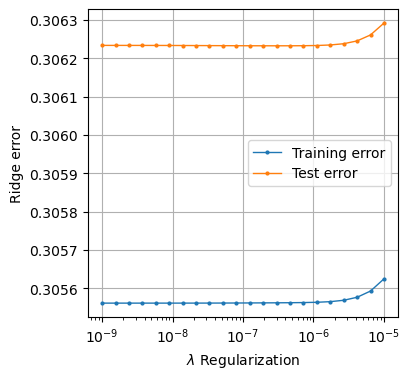

index of min :  13
lamdna at the min :  2.9935772947204905e-07


In [92]:
seed=104
k_fold=4
mse_tr_Tot = {}
mse_val_Tot = {}
lambdas = np.logspace(-9, -5, 22)
minimum = np.zeros(len(N_values), dtype=int)
i = 0

for N in N_values:
    k_indices = build_k_indices(y_train_over_N[N], k_fold, seed) 
    mse_tr = []
    mse_val = []
    
    for ind, lambda_ in enumerate(lambdas):
        mse_tr_tmp=[]
        mse_val_tmp=[]

        for ind2, k in enumerate(range(k_fold)): 
            tr_indices=(k_indices[:]!=k_indices[k])
            x_train_=x_train_with1[N][k_indices[tr_indices]]
            y_train_=y_train_over_N[N][k_indices[tr_indices]] 
            x_test_=x_train_with1[N][k_indices[k]]
            y_test_=y_train_over_N[N][k_indices[k]] 

            w, mse=ridge_regression(y_train_, x_train_, lambda_)
    
            mse_tr_tmp.append(mse)
            mse_val_tmp.append(compute_loss_mse(y_test_, x_test_, w))

        mse_tr.append(np.mean(mse_tr_tmp))
        mse_val.append(np.mean(mse_val_tmp))
    mse_tr_Tot[N] = mse_tr
    mse_val_Tot[N] = mse_val
    # Plot the MSE curve in function of lambda
    plt.figure(figsize=(4,4))
    plt.plot(lambdas, mse_tr, label='Training error', marker='o', markersize=2, linewidth=1)
    plt.plot(lambdas,  mse_val_Tot[N], label='Test error', marker='o', markersize=2, linewidth=1)

    plt.xscale('log')  # as lambda is in log scale
    plt.xlabel(r'$\lambda$ Regularization')
    plt.ylabel('Ridge error')
    #plt.title('Training and Validation Logistic vs Lambda')
    plt.legend()
    plt.grid(True)
    plt.show()
    minimum[i]=np.argmin( mse_val_Tot[N])
    print("index of min : ",minimum[i])
    print("lamdna at the min : ",lambdas[minimum[i]])
    i+=1

### Best Penality/treshold Check
we now search a good value for a treshold, which would maximize our F1 score (for each N times (+1) augmented dataset)

In [100]:
import importlib
import implementations

importlib.reload(implementations)

from implementations import *

w = {}
y_pred = {}
i = 0
penalties = np.linspace(-0.7,0.2, 1000)
f1_cris_card_scores_N = {}
f1_non_cris_card_scores_N = {}    
y_test=Y_te_
indice_max = {}
pen_max = {}

F1_max=[]


for N in N_values:
    w[N], mse=ridge_regression(y_train_over_N[N],x_train_with1[N], lambdas[minimum[N-1]])  #minimum is a vector and need to start at 0, thus the -1 term since N start at 1

    f1_cris_card_scores = []
    f1_non_cris_card_scores = []    
    y_pred[N]=x_testSplit_with1 @ w[N]
    
    for penalty in penalties:
        # Adjusting predictions based on the penalty/treshold
        y_pred_adjusted = np.sign(y_pred[N] - penalty)
    
        # Predictions for the classes
        cris_card_pred = (y_pred_adjusted == 1)
        non_cris_card_pred = (y_pred_adjusted == -1)
    
        # Calcul of the F1 score 
        f1_cris_card, f1_non_cris_card = classification_metrics2(y_pred_adjusted, y_test, returnF1=True)
        f1_cris_card_scores.append(f1_cris_card)
        f1_non_cris_card_scores.append(f1_non_cris_card)
    '''
    # PLOT OF PENALTY FOR EACH N AUGMENTED DATASET
    plt.plot(penalties, f1_cris_card_scores, label='F1 score crise cardiaque', marker='o', markersize=2, linestyle='-', linewidth=1, color='r')
    plt.plot(penalties, f1_non_cris_card_scores, label='F1 score non-crise cardiaque', marker='o', markersize=2, linestyle='-', linewidth=1, color='b')
    
    # Ajouter des étiquettes et une légende
    plt.xlabel('Pénalité')
    plt.ylabel('Score F1')
    plt.title('Score F1 en fonction de la pénalité')
    plt.grid('on')
    plt.legend()
    plt.show()
    '''

    f1_cris_card_scores_N[N] = f1_cris_card_scores
    f1_non_cris_card_scores_N[N] = f1_non_cris_card_scores
    indice_max[N]=np.argmax(f1_cris_card_scores)
    pen_max[N] = penalties[indice_max[N]]
    F1_max.append(f1_cris_card_scores[indice_max[N]])
    print("N=",N)
    print("Best F1 score for this N: ",F1_max[N-1])
    print("Penalty used for best F1 score: ",penalties[indice_max[N]])
    i+=1

print(F1_max)

N= 1
Best F1 score for this N:  0.41046756336352824
Penalty used for best F1 score:  -0.5585585585585585
N= 2
Best F1 score for this N:  0.41091639284410364
Penalty used for best F1 score:  -0.3045045045045045
N= 3
Best F1 score for this N:  0.41190608245516724
Penalty used for best F1 score:  -0.12702702702702706
N= 4
Best F1 score for this N:  0.4131294964028777
Penalty used for best F1 score:  -0.017117117117117164
N= 5
Best F1 score for this N:  0.41288566243194186
Penalty used for best F1 score:  0.08288288288288281
N= 6
Best F1 score for this N:  0.41259812368370674
Penalty used for best F1 score:  0.19009009009009004
[0.41046756336352824, 0.41091639284410364, 0.41190608245516724, 0.4131294964028777, 0.41288566243194186, 0.41259812368370674]


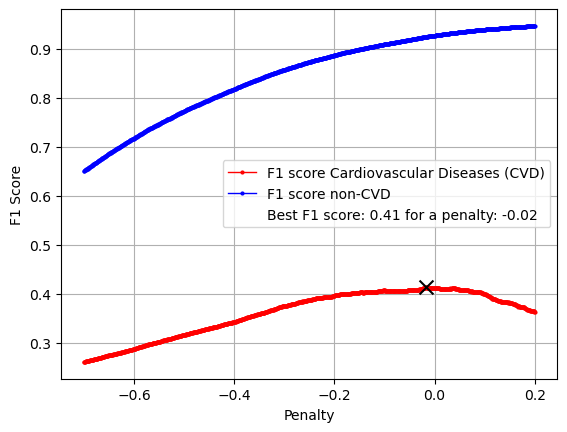

good treshold T= -0.017117117117117164
best F1 :  0.4131294964028777


In [101]:
# Définition des coordonnées du point noir
x_value =  penalties[indice_max[np.argmax(F1_max)+1]]
y_value = np.max(F1_max)
# Tracer les courbes de F1 en fonction de la pénalité
plt.plot(penalties, f1_cris_card_scores_N[np.argmax(F1_max)+1], label='F1 score Cardiovascular Diseases (CVD)', marker='o', markersize=2, linestyle='-', linewidth=1, color='r')
plt.plot(penalties, f1_non_cris_card_scores_N[np.argmax(F1_max)+1], label='F1 score non-CVD', marker='o', markersize=2, linestyle='-', linewidth=1, color='b')

# Tracer la croix noire avec un zorder plus élevé pour qu'elle apparaisse devant
plt.scatter(x_value, y_value, color='black', marker='x', s=100, zorder=2)

# Ajouter une ligne invisible avec le texte souhaité pour qu'elle apparaisse dans la légende
plt.plot([], [], ' ', label=f"Best F1 score: {y_value:.2f} for a penalty: {x_value:.2f}")

# Ajouter des étiquettes et une légende
plt.xlabel('Penalty')
plt.ylabel('F1 Score')
plt.grid('on')
plt.legend()
plt.show()

print("good treshold T=",x_value)
print("best F1 : ", y_value)


In [102]:
x_test_with1= np.concatenate((np.ones((x_test0.shape[0], 1)), x_test0), axis=1)

print(x_test_with1.shape)
print(w[np.argmax(F1_max)+1].shape)

pen=penalties[indice_max[np.argmax(F1_max)+1]]
print("penalty=", pen)
prediction=x_test_with1 @ w[np.argmax(F1_max)+1] - pen
prediction_signed=np.sign(prediction)

print(prediction_signed)
count_neg1 = np.sum(prediction_signed == -1)
count_1 = np.sum(prediction_signed == 1)

print(f"Number of -1: {count_neg1}")
print(f"Number of 1: {count_1}")

create_csv_submission(test_ids, prediction_signed, "y_RIDGE_data_augmented")

(109379, 319)
(319,)
penalty= -0.017117117117117164
[-1. -1. -1. ... -1.  1. -1.]
Number of -1: 94033
Number of 1: 15346


# RIDGE REGRESSION 2
(with reduced dataset)

This time, instead of adding +1 points, we try to remove -1 points, and see if it is best or not

In [121]:
import importlib
import implementations
importlib.reload(implementations)
from implementations import *

del y_train_over_N, X_train_over_N, x_train_with1

In [123]:
#Init Variables
N_values = [1,2,3,4,5,6]  
y_train_over_N = {}
X_train_over_N = {}
indices = np.where(Y_tr_ == 1)[0]

# run over the different N values, import only a fraction of total data
# here, in the datas there is N  times more -1 than 1
for N in N_values:     
    X_train_over_N[N], y_train_over_N[N], = downsample_data(X_tr_, Y_tr_, N)

In [46]:
x_train_with1 = {}

for n in N_values:
    x_train_with1[n] = np.concatenate((np.ones((X_train_over_N[n].shape[0], 1)), X_train_over_N[n]), axis=1)

x_testSplit_with1 = np.concatenate((np.ones((X_te_.shape[0], 1)), X_te_), axis=1)
x_test_with1= np.concatenate((np.ones((x_test0.shape[0], 1)), x_test0), axis=1)

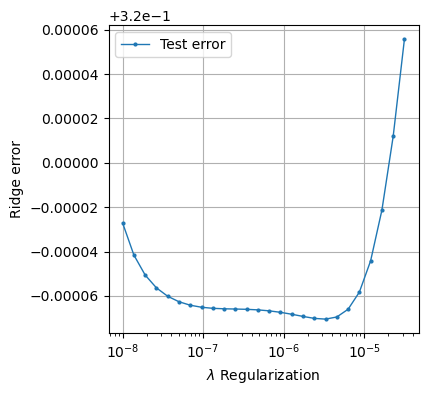

index of min :  18
lamdna at the min :  3.3113112148259145e-06


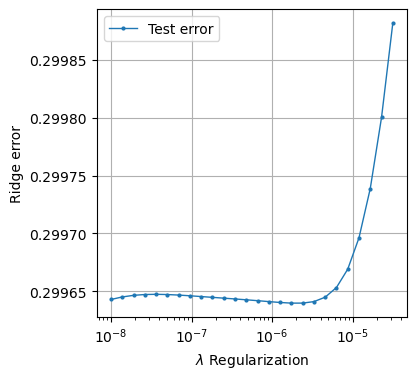

index of min :  16
lamdna at the min :  1.7378008287493763e-06


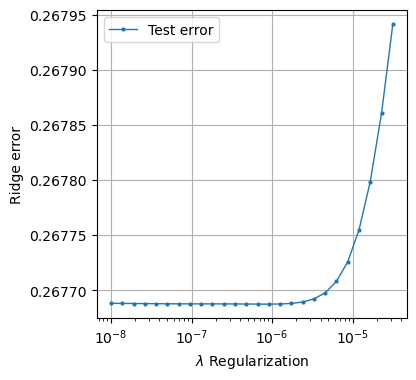

index of min :  14
lamdna at the min :  9.120108393559096e-07


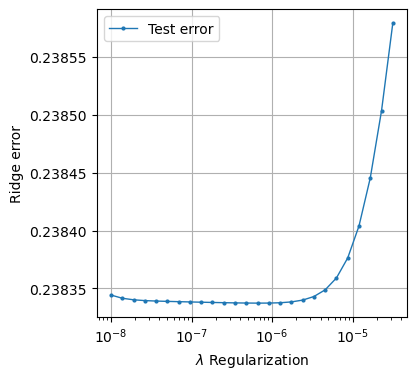

index of min :  13
lamdna at the min :  6.606934480075964e-07


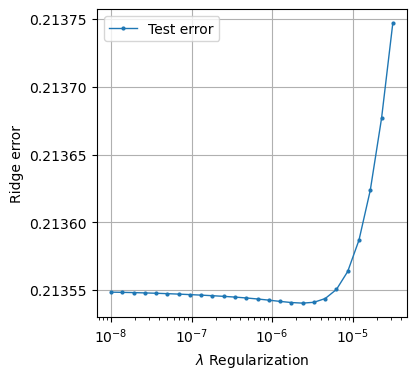

index of min :  17
lamdna at the min :  2.3988329190194948e-06


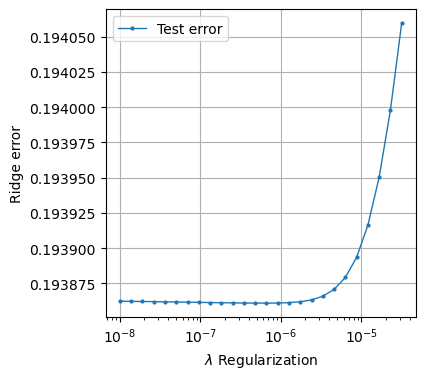

index of min :  13
lamdna at the min :  6.606934480075964e-07


In [47]:
seed=104
k_fold=4
mse_tr_Tot = {}
mse_val_Tot = {}
lambdas = np.logspace(-8, -4.5, 26)
minimum = np.zeros(len(N_values), dtype=int)
i = 0

for N in N_values:
#for std in std_values:
    k_indices = build_k_indices(y_train_over_N[N], k_fold, seed) 
    mse_tr = []
    mse_val = []
    
    for ind, lambda_ in enumerate(lambdas):
        mse_tr_tmp=[]
        mse_val_tmp=[]

        for ind2, k in enumerate(range(k_fold)): 
            tr_indices=(k_indices[:]!=k_indices[k])
            x_train_=x_train_with1[N][k_indices[tr_indices]]
            y_train_=y_train_over_N[N][k_indices[tr_indices]] 
            x_test_=x_train_with1[N][k_indices[k]]
            y_test_=y_train_over_N[N][k_indices[k]] 

            w, mse=ridge_regression(y_train_, x_train_, lambda_)
    
            mse_tr_tmp.append(mse)
            mse_val_tmp.append(compute_loss_mse(y_test_, x_test_, w))

        mse_tr.append(np.mean(mse_tr_tmp))
        mse_val.append(np.mean(mse_val_tmp))
    mse_tr_Tot[N] = mse_tr
    mse_val_Tot[N] = mse_val
    # Plot the MSE curve in function of lambda
    plt.figure(figsize=(4,4))
    #plt.plot(lambdas, mse_tr, label='Training error', marker='o', markersize=2, linewidth=1)
    plt.plot(lambdas,  mse_val_Tot[N], label='Test error', marker='o', markersize=2, linewidth=1)

    plt.xscale('log')  # as lambda is in log scale
    plt.xlabel(r'$\lambda$ Regularization')
    plt.ylabel('Ridge error')
    #plt.title('Training and Validation Logistic vs Lambda')
    plt.legend()
    plt.grid(True)
    plt.show()
    minimum[i]=np.argmin( mse_val_Tot[N])
    print("index of min : ",minimum[i])
    print("lamdna at the min : ",lambdas[minimum[i]])
    i+=1

### Best Penality/treshold Check


In [48]:
import importlib
import implementations

importlib.reload(implementations)

from implementations import *

w = {}
y_pred = {}
i = 0
penalties = np.linspace(-0.7,1.2, 1000)
f1_cris_card_scores_N = {}
f1_non_cris_card_scores_N = {}    
y_test=Y_te_
indice_max = {}
pen_max = {}

F1_max=[]

#for std in std_values: 
for N in N_values:
    w[N], mse=ridge_regression(y_train_over_N[N],x_train_with1[N], lambdas[minimum[N-1]])  #minimum is a vector and need to start at 0, thus the -1 term since N start at 1

    f1_cris_card_scores = []
    f1_non_cris_card_scores = []    
    y_pred[N]=x_testSplit_with1 @ w[N]
    
    for penalty in penalties:
        # Adjusting predictions based on the penalty
        y_pred_adjusted = np.sign(y_pred[N] - penalty)
    
        # Predictions for the classes
        cris_card_pred = (y_pred_adjusted == 1)
        non_cris_card_pred = (y_pred_adjusted == -1)
    
        # Calcul of the F1 score 
        f1_cris_card, f1_non_cris_card = classification_metrics2(y_pred_adjusted, y_test, returnF1=True)
        f1_cris_card_scores.append(f1_cris_card)
        f1_non_cris_card_scores.append(f1_non_cris_card)
  

    f1_cris_card_scores_N[N] = f1_cris_card_scores
    f1_non_cris_card_scores_N[N] = f1_non_cris_card_scores
    indice_max[N]=np.argmax(f1_cris_card_scores)
    pen_max[N] = penalties[indice_max[N]]
    F1_max.append(f1_cris_card_scores[indice_max[N]])
    print("N=",N)
    print("Best F1 score for this N: ",F1_max[N-1])
    print("Penalty used for best F1 score: ",penalties[indice_max[N]])
    i+=1
    
    print("")
    
print(F1_max) 

N= 1
Best F1 score for this N:  0.4092135697764071
Penalty used for best F1 score:  0.4050050050050049

N= 2
Best F1 score for this N:  0.4116589382038422
Penalty used for best F1 score:  0.12352352352352347

N= 3
Best F1 score for this N:  0.41219265125702187
Penalty used for best F1 score:  -0.06856856856856852

N= 4
Best F1 score for this N:  0.41153590740916424
Penalty used for best F1 score:  -0.17887887887887888

N= 5
Best F1 score for this N:  0.41218103929968336
Penalty used for best F1 score:  -0.2815815815815816

N= 6
Best F1 score for this N:  0.4113462720646351
Penalty used for best F1 score:  -0.38048048048048044

[0.4092135697764071, 0.4116589382038422, 0.41219265125702187, 0.41153590740916424, 0.41218103929968336, 0.4113462720646351]


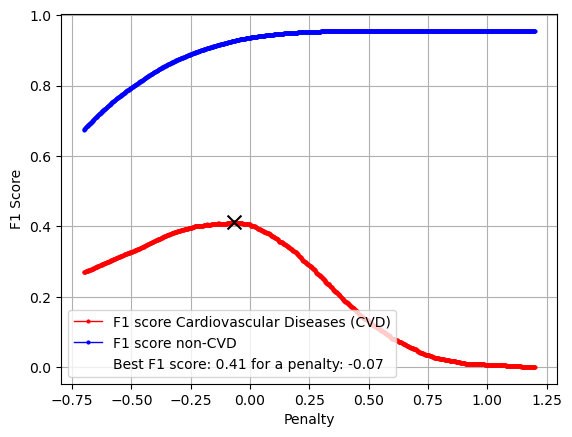

In [49]:
# Définition des coordonnées du point noir
x_value =  penalties[indice_max[np.argmax(F1_max)+1]]
y_value =np.max(F1_max)
# Tracer les courbes de F1 en fonction de la pénalité
plt.plot(penalties, f1_cris_card_scores_N[np.argmax(F1_max)+1], label='F1 score Cardiovascular Diseases (CVD)', marker='o', markersize=2, linestyle='-', linewidth=1, color='r')
plt.plot(penalties, f1_non_cris_card_scores_N[np.argmax(F1_max)+1], label='F1 score non-CVD', marker='o', markersize=2, linestyle='-', linewidth=1, color='b')

# Tracer la croix noire avec un zorder plus élevé pour qu'elle apparaisse devant
plt.scatter(x_value, y_value, color='black', marker='x', s=100, zorder=2)

# Ajouter une ligne invisible avec le texte souhaité pour qu'elle apparaisse dans la légende
plt.plot([], [], ' ', label=f"Best F1 score: {y_value:.2f} for a penalty: {x_value:.2f}")

# Ajouter des étiquettes et une légende
plt.xlabel('Penalty')
plt.ylabel('F1 Score')
plt.grid('on')
plt.legend()
plt.show()

print("good treshold T=",x_value)
print("best F1 : ", y_value)


In [50]:
x_test_with1= np.concatenate((np.ones((x_test0.shape[0], 1)), x_test0), axis=1)

print(x_test_with1.shape)
print(w[np.argmax(F1_max)+1].shape)
pen=penalties[indice_max[np.argmax(F1_max)+1]]
print("penalty=", pen)

prediction=x_test_with1 @ w[np.argmax(F1_max)+1] - pen
prediction_signed=np.sign(prediction)

print(prediction_signed)
count_neg1 = np.sum(prediction_signed == -1)
count_1 = np.sum(prediction_signed == 1)

print(f"Number of -1: {count_neg1}")
print(f"Number of 1: {count_1}")

create_csv_submission(test_ids, prediction_signed, "y_RIDGE_reduced_data")

(109379, 319)
(319,)
penalty= -0.06856856856856852
[-1. -1. -1. ... -1.  1. -1.]
Number of -1: 94656
Number of 1: 14723


## REG LOGISTIC ##

reg logistic iter. 999/999: loss=0.3979028487142668
reg logistic iter. 999/999: loss=0.3970111659449659
reg logistic iter. 999/999: loss=0.3984137141665153
reg logistic iter. 999/999: loss=0.3998906548485391
k-fold losses :  [0.4029199667446418, 0.4058134995606978, 0.40174394876846226, 0.39723091974802227]

reg logistic iter. 999/999: loss=0.3979031992329718
reg logistic iter. 999/999: loss=0.39701149985326656
reg logistic iter. 999/999: loss=0.3984140694239969
reg logistic iter. 999/999: loss=0.3998909807123816
k-fold losses :  [0.40291937273267586, 0.40581299555271655, 0.40174350752561994, 0.3972310902889583]

reg logistic iter. 999/999: loss=0.3979036604305806
reg logistic iter. 999/999: loss=0.39701193930300677
reg logistic iter. 999/999: loss=0.3984145367608749
reg logistic iter. 999/999: loss=0.39989140955757074
k-fold losses :  [0.4029185990035187, 0.4058123394876524, 0.40174293354424817, 0.39723131615654395]

reg logistic iter. 999/999: loss=0.3979042682985541
reg logistic iter

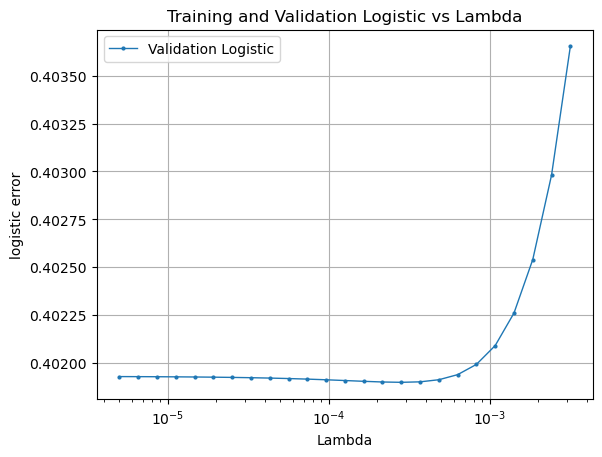

index of minimum :  15
lambda :  0.0002818382931264455


In [52]:
########### 
N_=np.argmax(F1_max)+1  # we take the best reduced N dataset from before, we add + 1 because y_train_over_N is a dictionnary
###########

k_fold=4
k_indices = build_k_indices(y_train_over_N[N_], k_fold, seed=202) 

initial_w=np.zeros(x_train_with1[N_].shape[1]) 

loss_tr = []
loss_val = []
lambdas = np.logspace(-5.3, -2.5, 25) 
max_iters=1000
gamma=0.3


for ind, lambda_ in enumerate(lambdas):
    loss_tr_tmp=[]
    loss_val_tmp=[]
    for ind2, k in enumerate(range(k_fold)):
        tr_indices=(k_indices[:]!=k_indices[k])
        x_train_=x_train_with1[N_][k_indices[tr_indices]]
        y_train_=y_train_over_N[N_][k_indices[tr_indices]] 
        x_test_=x_train_with1[N_][k_indices[k]]
        y_test_=y_train_over_N[N_][k_indices[k]] 

        w, loss=reg_logistic_regression(y_train_, x_train_, lambda_, initial_w, max_iters, gamma)
    
        loss_tr_tmp.append(loss)
        loss_val_tmp.append(compute_logistic_loss(y_test_, x_test_, w))

    print("k-fold losses : ", loss_val_tmp)
    print("")
    loss_tr.append(np.mean(loss_tr_tmp))
    loss_val.append(np.mean(loss_val_tmp))

#plt.plot(lambdas, loss_tr, label='Training Logistic', marker='o', markersize=2, linewidth=1)
plt.plot(lambdas, loss_val, label='Validation Logistic', marker='o', markersize=2, linewidth=1)

plt.xscale('log') 
plt.xlabel('Lambda')
plt.ylabel('logistic error')
plt.title('Training and Validation Logistic vs Lambda')
plt.legend()
plt.grid(True)
plt.show()

minimum=np.argmin(loss_val)
print("index of minimum : ",minimum)
print("lambda : ",lambdas[minimum])


In [58]:
w, loss =reg_logistic_regression(y_train_over_N[N_], x_train_with1[N_], lambdas[minimum], initial_w, max_iters, gamma)

classification_metrics2(np.sign(x_testSplit_with1 @ w ), Y_te_) 

reg logistic iter. 999/999: loss=0.39887061281512115
Accuracy: 0.87723
Non crise:    precision=0.94862     recall=0.91497     f1-score=0.93149     support=44902
Crise card:   precision=0.35419     recall=0.48483    cf1-score=0.40934     support=4319


### Best Penality/treshold Check


good treshold T= -0.17407407407407405
best F1 :  0.4178741865509761


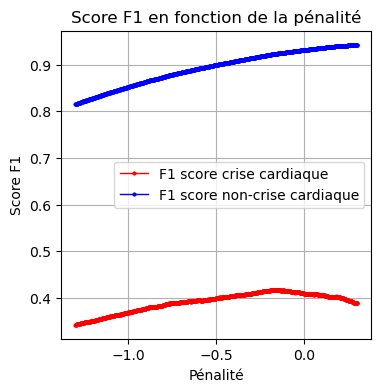

In [60]:
f1_cris_card_scores = []
f1_non_cris_card_scores = []
penalties = np.linspace(-1.3,0.3, 1000)

y_pred=x_testSplit_with1 @ w
y_test=Y_te_

for penalty in penalties:
    y_pred_adjusted = np.sign(y_pred - penalty)

    f1_cris_card, f1_non_cris_card=classification_metrics2(np.array(y_pred_adjusted), np.array(y_test), returnF1=True)

    f1_cris_card_scores.append(f1_cris_card)
    f1_non_cris_card_scores.append(f1_non_cris_card)

plt.figure(figsize=(4,4))
plt.plot(penalties, f1_cris_card_scores, label='F1 score crise cardiaque', marker='o', markersize=2, linestyle='-', linewidth=1, color='r')
plt.plot(penalties, f1_non_cris_card_scores, label='F1 score non-crise cardiaque', marker='o', markersize=2, linestyle='-', linewidth=1, color='b')

plt.xlabel('Pénalité')
plt.ylabel('Score F1')
plt.title('Score F1 en fonction de la pénalité')
plt.grid('on')
plt.legend()

indice_max=np.argmax(f1_cris_card_scores)
print("good treshold T=",penalties[indice_max])
print("best F1 : ", f1_cris_card_scores[indice_max])

In [61]:
x_test_with1= np.concatenate((np.ones((x_test0.shape[0], 1)), x_test0), axis=1)

pen=penalties[indice_max]

y_pred= np.sign(x_test_with1 @ w - pen)  #similar expression to y_pred = np.where(sigmoid(x_test_with1 @ w - pen) >= 0.5, 1, -1), no need to calculate the sigmoid

create_csv_submission(test_ids, y_pred, "y_Reg_Logistic")

## SVM ##

In [48]:
import importlib
import implementations

importlib.reload(implementations)

from implementations import *

SVM iter. 999/999: loss=0.448343168907919
SVM iter. 999/999: loss=0.4424092547522519
SVM iter. 999/999: loss=0.4441081539518105
SVM iter. 999/999: loss=0.44512319982536513
k-fold losses :  [0.448343168907919, 0.4424092547522519, 0.4441081539518105, 0.44512319982536513]

SVM iter. 999/999: loss=0.4426981123903139
SVM iter. 999/999: loss=0.44005278704269296
SVM iter. 999/999: loss=0.44264312870059674
SVM iter. 999/999: loss=0.4441240265407948
k-fold losses :  [0.4426981123903139, 0.44005278704269296, 0.44264312870059674, 0.4441240265407948]

SVM iter. 999/999: loss=0.44193715665248623
SVM iter. 999/999: loss=0.4395492250974502
SVM iter. 999/999: loss=0.44223215356847584
SVM iter. 999/999: loss=0.4437807264970505
k-fold losses :  [0.44193715665248623, 0.4395492250974502, 0.44223215356847584, 0.4437807264970505]

SVM iter. 999/999: loss=0.44165502411834767
SVM iter. 999/999: loss=0.4393494336331818
SVM iter. 999/999: loss=0.44206085349856306
SVM iter. 999/999: loss=0.44362319852834986
k-fo

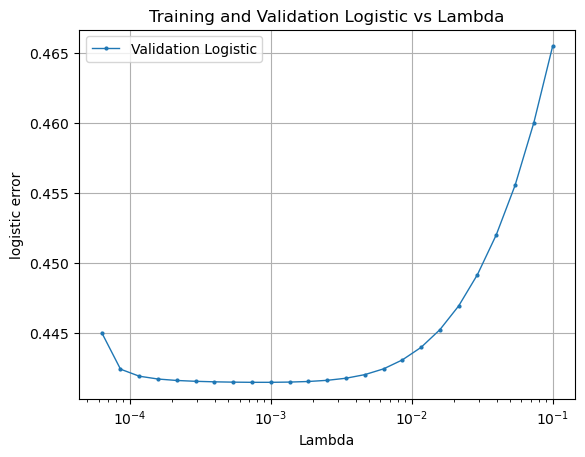

index of minimum :  8
lambda :  0.0007356422544596406


In [63]:
########### 
N_=np.argmax(F1_max)+1 #####
###########

k_fold=4
k_indices = build_k_indices(y_train_over_N[N_], k_fold, seed=202) 

initial_w=np.zeros(x_train_with1[N_].shape[1]) 

loss_tr = []
loss_val = []
lambdas = np.logspace(-4.2, -1.0, 25) 
max_iters=1000
gamma=0.5

ktest=[0]

for ind, lambda_ in enumerate(lambdas):
    loss_tr_tmp=[]
    loss_val_tmp=[]
    for ind2, k in enumerate(range(k_fold)):
        tr_indices=(k_indices[:]!=k_indices[k])
        x_train_=x_train_with1[N_][k_indices[tr_indices]]
        y_train_=y_train_over_N[N_][k_indices[tr_indices]] 
        x_test_=x_train_with1[N_][k_indices[k]]
        y_test_=y_train_over_N[N_][k_indices[k]] 

        w, loss=sgd_for_svm_demo(y_train_, x_train_, lambda_, initial_w, max_iters, gamma)
    
        loss_tr_tmp.append(loss)
        loss_val_tmp.append(calculate_primal_objective(y_train_, x_train_, w, lambda_))

    print("k-fold losses : ", loss_val_tmp)
    print("")
    loss_tr.append(np.mean(loss_tr_tmp))
    loss_val.append(np.mean(loss_val_tmp))

#plt.plot(lambdas, loss_tr, label='Training Logistic', marker='o', markersize=2, linewidth=1)
plt.plot(lambdas, loss_val, label='Validation Logistic', marker='o', markersize=2, linewidth=1)

plt.xscale('log') 
plt.xlabel('Lambda')
plt.ylabel('logistic error')
plt.title('Training and Validation Logistic vs Lambda')
plt.legend()
plt.grid(True)
plt.show()

minimum=np.argmin(loss_val)
print("index of minimum : ",minimum)
print("lambda : ",lambdas[minimum])


In [64]:
w, loss =sgd_for_svm_demo(y_train_over_N[N_], x_train_with1[N_], lambdas[minimum], initial_w, max_iters, gamma)

classification_metrics2(np.sign(x_testSplit_with1 @ w ), Y_te_) 

SVM iter. 999/999: loss=0.4468464902520358
Accuracy: 0.88529
Non crise:    precision=0.94496     recall=0.92833     f1-score=0.93657     support=44902
Crise card:   precision=0.37013     recall=0.43783    cf1-score=0.40115     support=4319


### Best Penality/treshold Check


good treshold T= -0.1561561561561562
best F1 :  0.41184137032210016


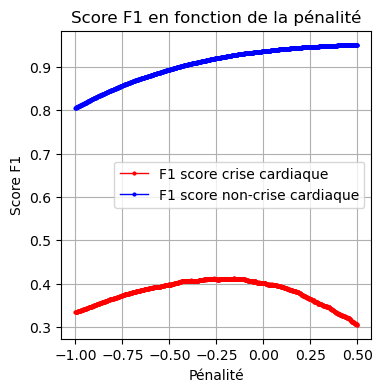

In [66]:
f1_cris_card_scores = []
f1_non_cris_card_scores = []
penalties = np.linspace(-1,0.5, 1000)

y_pred=x_testSplit_with1 @ w
y_test=Y_te_

for penalty in penalties:
    y_pred_adjusted = np.sign(y_pred - penalty)

    f1_cris_card, f1_non_cris_card=classification_metrics2(np.array(y_pred_adjusted), np.array(y_test), returnF1=True)

    f1_cris_card_scores.append(f1_cris_card)
    f1_non_cris_card_scores.append(f1_non_cris_card)

plt.figure(figsize=(4,4))
plt.plot(penalties, f1_cris_card_scores, label='F1 score crise cardiaque', marker='o', markersize=2, linestyle='-', linewidth=1, color='r')
plt.plot(penalties, f1_non_cris_card_scores, label='F1 score non-crise cardiaque', marker='o', markersize=2, linestyle='-', linewidth=1, color='b')

# Ajouter des étiquettes et une légende
plt.xlabel('Pénalité')
plt.ylabel('Score F1')
plt.title('Score F1 en fonction de la pénalité')
plt.grid('on')
plt.legend()

indice_max=np.argmax(f1_cris_card_scores)
print("good treshold T=",penalties[indice_max])
print("best F1 : ", f1_cris_card_scores[indice_max])

In [67]:
x_test_with1= np.concatenate((np.ones((x_test0.shape[0], 1)), x_test0), axis=1)

pen=penalties[indice_max]

y_pred= np.sign(x_test_with1 @ w - pen) 

create_csv_submission(test_ids, y_pred, "y_SVM_stochastic")

## BONNUS : Ridge and polynome ##

Inspired by what was seen in class (the slide where x data in dim 1 are passed in dim 2 with x --> phi(x)=(x,x^2)), and by serie 3, we tried to use polynomial approximation

Indeed, it is very not likely that the data are perfectly linearly separable. Thus, the use of kernel could be very good ! Unfortunately, N is way too large to use kernels, and this method may be not appropriate here. 

Nevertheless, we did a similar function to what was done in serie 3 (polynomial fit), but here only up to a degree 2, for each features. Thus, going from 318 initial features to 318*2.

The F1 score here on our Y_te_ dataset (unspoiled, we never train on it, it is completely independant) is better than all previous methods. And on AI crowd too. What a nice thing that wensday's lecture inspired us this :D

In [68]:
def create_polynomial_features(x_array, degree):
    bias = x_array[:, :1]
    features = x_array[:, 1:]
    
    n_samples, n_features = features.shape
    poly_features = np.empty((n_samples, 0), dtype=np.float32)

    for i in range(n_features):
        feat = features[:, i]
        vander_matrix = np.vander(feat, degree + 1, increasing=True)[:, 1:]
        poly_features = np.concatenate((poly_features, vander_matrix), axis=1)

    poly_features_with_bias = np.concatenate((bias, poly_features), axis=1)
    
    return poly_features_with_bias

In [106]:
del y_train_over_N, X_train_over_N, x_train_with1

In [124]:
# We add a first row full of one to have y = w0 +w1*X1 + ...
x_train_with1 = {}

for n in N_values:
        x_train_with1[n] = create_polynomial_features( 
                np.concatenate((np.ones((X_train_over_N[n].shape[0], 1)), X_train_over_N[n]), axis=1),
                degree=2
        )

x_testSplit_with1 = create_polynomial_features( np.concatenate((np.ones((X_te_.shape[0], 1)), X_te_), axis=1), degree=2 )
x_test_with1= create_polynomial_features( np.concatenate((np.ones((x_test0.shape[0], 1)), x_test0), axis=1), degree=2 )

In [125]:
#see the feature augmentation:
print(x_train_with1[1].shape)
print(x_testSplit_with1.shape)
print(x_test_with1.shape)

(49312, 637)
(49221, 637)
(109379, 637)


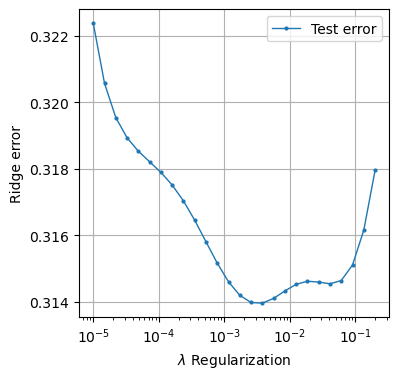

index of min :  15
lamdna at the min :  0.003801893963205609


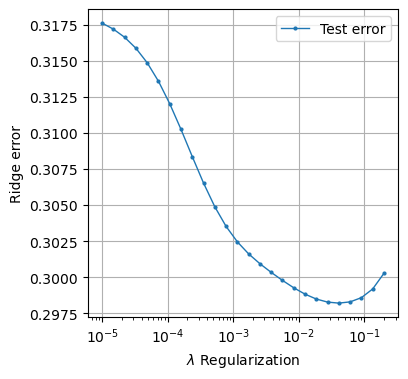

index of min :  21
lamdna at the min :  0.04092606597300105


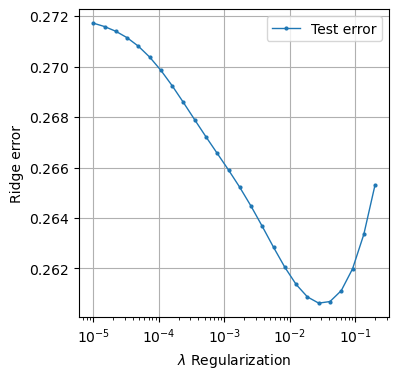

index of min :  20
lamdna at the min :  0.027542287033381633


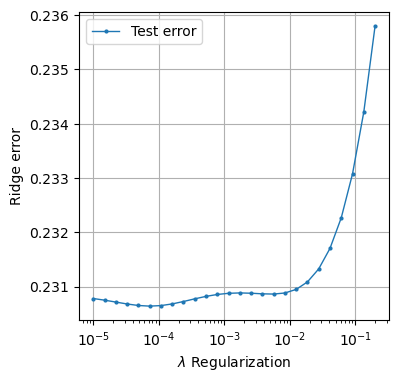

index of min :  5
lamdna at the min :  7.244359600749891e-05


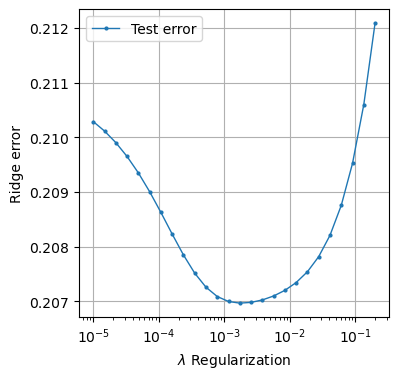

index of min :  13
lamdna at the min :  0.0017218685749860062


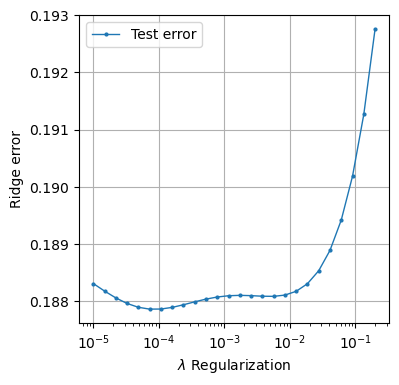

index of min :  5
lamdna at the min :  7.244359600749891e-05


In [126]:
seed=104
k_fold=5
mse_tr_Tot = {}
mse_val_Tot = {}
lambdas = np.logspace(-5, -0.7, 26)
minimum = np.zeros(len(N_values), dtype=int)
i = 0

for N in N_values:
    k_indices = build_k_indices(y_train_over_N[N], k_fold, seed)
    mse_tr = []
    mse_val = []
    
    for ind, lambda_ in enumerate(lambdas):
        mse_tr_tmp=[]
        mse_val_tmp=[]

        for ind2, k in enumerate(range(k_fold)): 
            tr_indices=(k_indices[:]!=k_indices[k])
            x_train_=x_train_with1[N][k_indices[tr_indices]]
            y_train_=y_train_over_N[N][k_indices[tr_indices]] 
            x_test_=x_train_with1[N][k_indices[k]]
            y_test_=y_train_over_N[N][k_indices[k]] 

            w, mse=ridge_regression(y_train_, x_train_, lambda_)
    
            mse_tr_tmp.append(mse)
            mse_val_tmp.append(compute_loss_mse(y_test_, x_test_, w))

        mse_tr.append(np.mean(mse_tr_tmp))
        mse_val.append(np.mean(mse_val_tmp))
    mse_tr_Tot[N] = mse_tr
    mse_val_Tot[N] = mse_val

    plt.figure(figsize=(4,4))
    #plt.plot(lambdas, mse_tr, label='Training error', marker='o', markersize=2, linewidth=1)
    plt.plot(lambdas,  mse_val_Tot[N], label='Test error', marker='o', markersize=2, linewidth=1)

    plt.xscale('log')  # as lambda is in log scale
    plt.xlabel(r'$\lambda$ Regularization')
    plt.ylabel('Ridge error')
    #plt.title('Training and Validation Logistic vs Lambda')
    plt.legend()
    plt.grid(True)
    plt.show()
    minimum[i]=np.argmin( mse_val_Tot[N])
    print("index of min : ",minimum[i])
    print("lamdna at the min : ",lambdas[minimum[i]])
    i+=1

### Best Penality/treshold Check


In [127]:
import importlib
import implementations

importlib.reload(implementations)

from implementations import *

w = {}
y_pred = {}
i = 0
penalties = np.linspace(-0.5,0.5, 1000)
f1_cris_card_scores_N = {}
f1_non_cris_card_scores_N = {}    
y_test=Y_te_
indice_max = {}
pen_max = {}

F1_max=[]

#for std in std_values: 
for N in N_values:
    w[N], mse=ridge_regression(y_train_over_N[N],x_train_with1[N], lambdas[minimum[N-1]])  #minimum is a vector and need to start at 0, thus the -1 term since N start at 1

    f1_cris_card_scores = []
    f1_non_cris_card_scores = []    
    y_pred[N]=x_testSplit_with1 @ w[N]
    
    for penalty in penalties:
        # Adjusting predictions based on the penalty
        y_pred_adjusted = np.sign(y_pred[N] - penalty)
    
        # Predictions for the classes
        cris_card_pred = (y_pred_adjusted == 1)
        non_cris_card_pred = (y_pred_adjusted == -1)
    
        # Calcul of the F1 score 
        f1_cris_card, f1_non_cris_card = classification_metrics2(y_pred_adjusted, y_test, returnF1=True)
        f1_cris_card_scores.append(f1_cris_card)
        f1_non_cris_card_scores.append(f1_non_cris_card)

    f1_cris_card_scores_N[N] = f1_cris_card_scores
    f1_non_cris_card_scores_N[N] = f1_non_cris_card_scores
    indice_max[N]=np.argmax(f1_cris_card_scores)
    pen_max[N] = penalties[indice_max[N]]
    F1_max.append(f1_cris_card_scores[indice_max[N]])
    print("N=",N)
    print("Best F1 score for this N: ",F1_max[N-1])
    print("Penalty used for best F1 score: ",penalties[indice_max[N]])
    i+=1
    
    print("")
    
print(F1_max) 

N= 1
Best F1 score for this N:  0.4273272692084381
Penalty used for best F1 score:  0.39289289289289286

N= 2
Best F1 score for this N:  0.42948483741322613
Penalty used for best F1 score:  0.08158158158158157

N= 3
Best F1 score for this N:  0.4310375831684949
Penalty used for best F1 score:  -0.10060060060060061

N= 4
Best F1 score for this N:  0.4313270226826219
Penalty used for best F1 score:  -0.21671671671671672

N= 5
Best F1 score for this N:  0.43042772062804546
Penalty used for best F1 score:  -0.3028028028028028

N= 6
Best F1 score for this N:  0.42827868852459017
Penalty used for best F1 score:  -0.39989989989989994

[0.4273272692084381, 0.42948483741322613, 0.4310375831684949, 0.4313270226826219, 0.43042772062804546, 0.42827868852459017]


In [85]:
print(np.argmax(F1_max)+1)

4


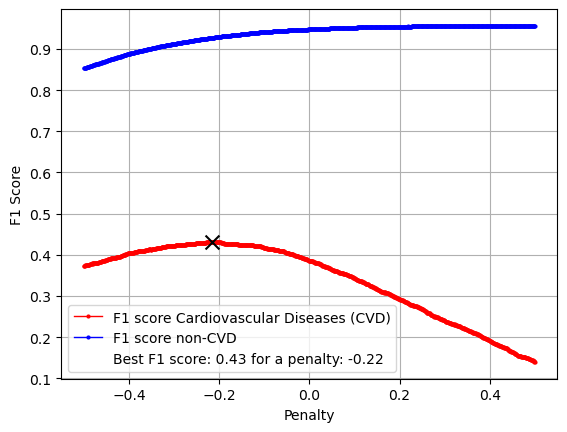

In [128]:
# Définition des coordonnées du point noir
x_value =  penalties[indice_max[np.argmax(F1_max)+1]]
y_value =np.max(F1_max)
# Tracer les courbes de F1 en fonction de la pénalité
plt.plot(penalties, f1_cris_card_scores_N[np.argmax(F1_max)+1], label='F1 score Cardiovascular Diseases (CVD)', marker='o', markersize=2, linestyle='-', linewidth=1, color='r')
plt.plot(penalties, f1_non_cris_card_scores_N[np.argmax(F1_max)+1], label='F1 score non-CVD', marker='o', markersize=2, linestyle='-', linewidth=1, color='b')

# Tracer la croix noire avec un zorder plus élevé pour qu'elle apparaisse devant
plt.scatter(x_value, y_value, color='black', marker='x', s=100, zorder=2)

# Ajouter une ligne invisible avec le texte souhaité pour qu'elle apparaisse dans la légende
plt.plot([], [], ' ', label=f"Best F1 score: {y_value:.2f} for a penalty: {x_value:.2f}")

# Ajouter des étiquettes et une légende
plt.xlabel('Penalty')
plt.ylabel('F1 Score')
plt.grid('on')
plt.legend()
plt.show()



In [120]:

print(x_test_with1.shape)
print(w[np.argmax(F1_max)+1].shape)
pen=penalties[indice_max[np.argmax(F1_max)+1]]
print("penalty=", pen)

prediction=x_test_with1 @ w[np.argmax(F1_max)+1] - pen
prediction_signed=np.sign(prediction)

print(prediction_signed)
count_neg1 = np.sum(prediction_signed == -1)
count_1 = np.sum(prediction_signed == 1)

print(f"Number of -1: {count_neg1}")
print(f"Number of 1: {count_1}")

create_csv_submission(test_ids, prediction_signed, "y_RIDGE_polynome_2")

(109379, 637)
(637,)
penalty= -0.22072072072072074
[-1. -1. -1. ... -1.  1. -1.]
Number of -1: 93311
Number of 1: 16068
